# bibliotecas

In [2]:
import numpy as np
import pandas as pd
import datetime
import yfinance as yf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import xgboost as xgb

import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OGradientBoostingEstimator, H2ODeepLearningEstimator

import warnings

h2o:1: DeprecationWarning: Your Python version is 3.10.2. The support for this version will be removed in H2O 3.42.0.1.


In [3]:
warnings.filterwarnings("ignore")

# funções

In [4]:
def compute_rsi(data, time_window):
    diff = data.diff(1).dropna()
    gains = 0 * diff
    losses = 0 * diff
    gains[diff > 0] = diff[diff > 0]
    losses[diff < 0] = -diff[diff < 0]
    avg_gains = gains.rolling(window=time_window, min_periods=time_window).mean()
    avg_losses = losses.rolling(window=time_window, min_periods=time_window).mean()
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(data, slow_period, fast_period, signal_period):
    ema_slow = data.ewm(span=slow_period).mean()
    ema_fast = data.ewm(span=fast_period).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal_period).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def compute_obv(data):
    obv = [0]
    for i in range(1, len(data)):
        if data[i] > data[i-1]:
            obv.append(obv[-1] + data[i])
        elif data[i] < data[i-1]:
            obv.append(obv[-1] - data[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=data.index)

In [5]:
def plot_real_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(20, 5))
    
    # Criar um DataFrame com os valores previstos e o índice de y_test
    y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])

    plt.plot(y_test, label='Real', linestyle='-', marker='o')
    plt.plot(y_pred_df, label='Previsto', linestyle='--', marker='x')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.title('(Dados de Teste) - Valor Real vs Valor Previsto')
    plt.legend()
    plt.show()

def plot_real_vs_predicted_numpy(y_test, y_pred):
    plt.figure(figsize=(20, 5))
    
    plt.plot(y_test, label='Real', linestyle='-', marker='o')
    plt.plot(y_pred, label='Previsto', linestyle='--', marker='x')
    plt.xlabel('Índice')
    plt.ylabel('Preço')
    plt.title('(Dados de Teste) - Preço Real vs Preço Previsto')
    plt.legend()
    plt.show()


# data

In [6]:
# Get the data for the ^BVSP stock index
data = yf.download("^BVSP", start="2000-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


# feature engineering

In [7]:
# Calculate the moving averages
data["50ma"] = data["Close"].rolling(window=50, min_periods=0).mean()
data["200ma"] = data["Close"].rolling(window=200, min_periods=0).mean()

# Adicionar volatilidade (desvio padrão)
data['Volatility'] = data['Close'].rolling(window=14).std()

# Calcular RSI
data['RSI'] = compute_rsi(data['Close'], time_window=14)

# Calcular MACD
data['MACD'], data['MACD_signal'], data['MACD_hist'] = compute_macd(data['Close'], slow_period=26, fast_period=12, signal_period=9)
data = data.dropna()

# Adicionar a feature 'On Balance Volume'
data['OBV'] = compute_obv(data['Close'])
data = data.dropna()

# Criar a variável dependente (Close deslocado)
data['Close_shift'] = data['Close'].shift(-1)
data = data.dropna()

data

,Open,High,Low,Close,Adj Close,Volume,50ma,200ma,Volatility,RSI,MACD,MACD_signal,MACD_hist,OBV,Close_shift
Date,,,,,,,,,,,,,,,
2000-01-21,17188.0,17372.0,16901.0,17034.0,17034.0,0,16949.800000,16949.800000,688.404418,50.949945,121.435203,117.740738,3.694465,0.0,16972.0
2000-01-24,17049.0,17263.0,16972.0,16972.0,16972.0,0,16951.187500,16951.187500,611.486767,62.575724,94.191229,112.894425,-18.703196,-16972.0,17105.0
2000-01-26,16972.0,17105.0,16727.0,17105.0,17105.0,0,16960.235294,16960.235294,568.078330,60.247855,80.475640,106.261303,-25.785663,133.0,17081.0
2000-01-27,17114.0,17422.0,17081.0,17081.0,17081.0,0,16966.944444,16966.944444,492.717024,61.930426,67.470584,98.360837,-30.890253,-16948.0,16734.0
2000-01-28,17150.0,17252.0,16547.0,16734.0,16734.0,0,16954.684211,16954.684211,447.079516,55.027206,34.395778,85.380763,-50.984985,-33682.0,16388.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,107436.0,108383.0,106510.0,107317.0,107317.0,11494600,111316.620000,109523.510000,2314.289837,34.375636,-1560.919460,-1772.804547,211.885087,15486605.0,109698.0
2022-12-23,107552.0,109994.0,107552.0,109698.0,109698.0,12847100,111214.040000,109502.500000,2345.565595,51.017054,-1188.885950,-1656.020827,467.134877,15596303.0,108738.0
2022-12-26,109699.0,109755.0,108309.0,108738.0,108738.0,5219500,111102.800000,109477.875000,2271.568737,47.423683,-960.439344,-1516.904531,556.465187,15487565.0,108347.0


# model

In [8]:
# Separar features (X) e target (y)
X = data.drop(['Close_shift', 'Close'], axis=1)
y = data['Close_shift']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, shuffle=False)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## random forest

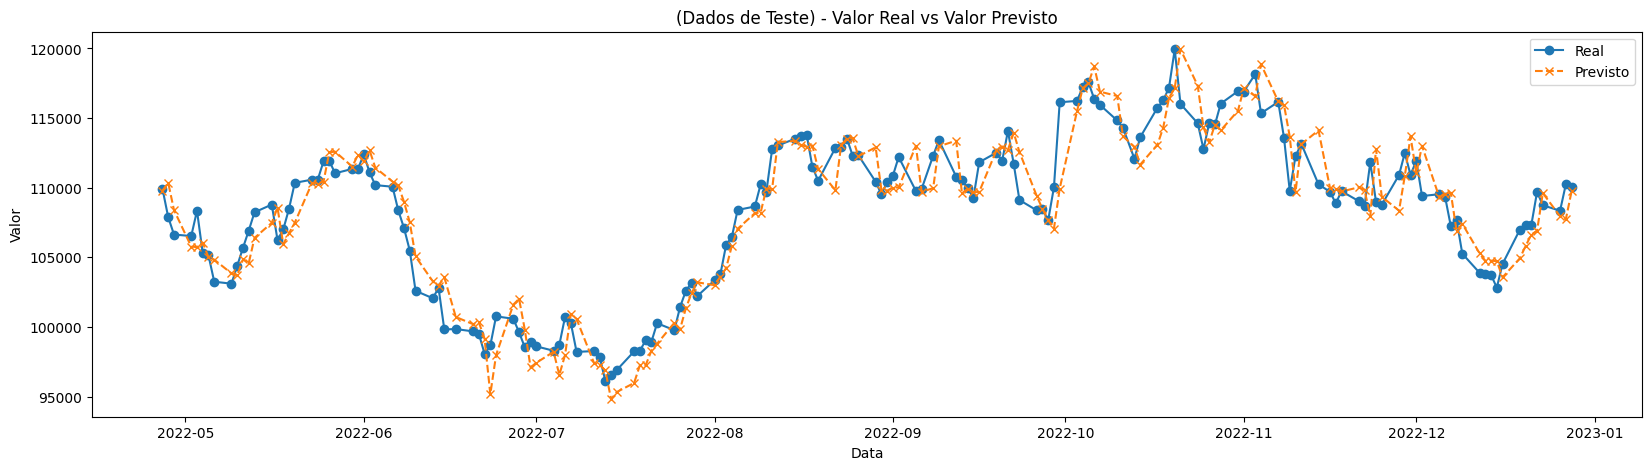

In [51]:
# Criar e treinar o modelo de ensemble (RandomForestRegressor)
params = {'n_estimators': [300], 'max_depth': [20]}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(RandomForestRegressor(), params, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

y_pred = grid_search.predict(X_test_scaled)
plot_real_vs_predicted(y_test, y_pred)

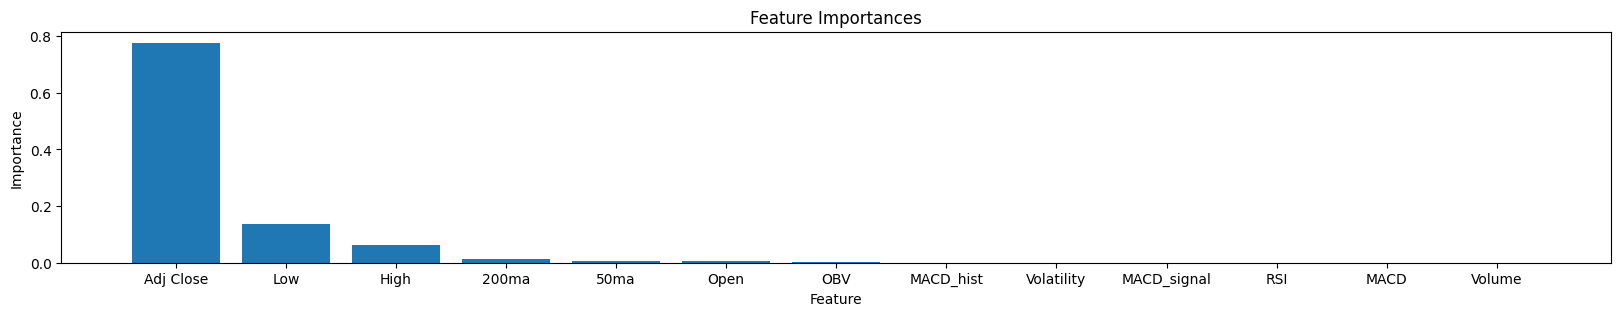

,3,2,1,6,5,0,12,11,7,10,8,9,4
Feature,Adj Close,Low,High,200ma,50ma,Open,OBV,MACD_hist,Volatility,MACD_signal,RSI,MACD,Volume
Importance,0.777034,0.134881,0.063424,0.012727,0.005158,0.004146,0.002185,0.00009,0.000083,0.00007,0.000069,0.000068,0.000064


In [54]:
# Obter a importância das features
best_estimator = grid_search.best_estimator_
feature_importances = best_estimator.feature_importances_

# Criar um DataFrame para visualizar a importância das features
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotar a importância das features
plt.figure(figsize=(20, 3))
plt.bar(features_df['Feature'], features_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

features_df.T

In [20]:
# Remover as features menos importantes
X_reduced = X.drop(['200ma','Open','MACD_hist','MACD_signal','Volatility','MACD','Volume','RSI'], axis=1)

# Dividir os dados em treino e teste novamente
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, shuffle=False)

# Normalizar os dados novamente
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# Treinar o modelo com os novos dados e hiperparâmetros otimizados
best_params = grid_search.best_params_
reduced_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
reduced_model.fit(X_train_scaled_reduced, y_train)

RandomForestRegressor(max_depth=15, n_estimators=300)

----------------------------------------------------------------------------------------------------
('MSE', 469139665.82401216)
('RMSE', 21659.632171946323)
('MAE', 18412.615765812105)
('R2', -1.4307428345362934)
('MAPE', 0.16651143356761058)
----------------------------------------------------------------------------------------------------


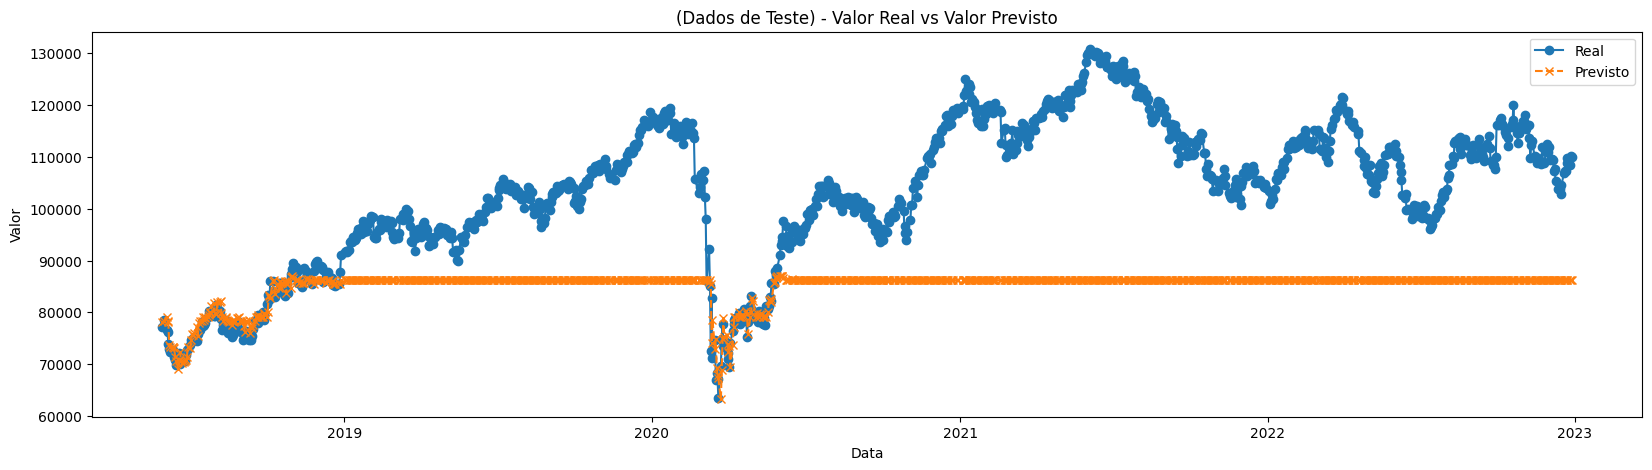

----------------------------------------------------------------------------------------------------


In [21]:
# Fazer previsões com o modelo reduzido
y_pred_reduced = reduced_model.predict(X_test_scaled_reduced)

# Calcule as métricas de avaliação
mse = mean_squared_error(y_test, y_pred_reduced)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_reduced)
r2 = r2_score(y_test, y_pred_reduced)
mape = mean_absolute_percentage_error(y_test, y_pred_reduced)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'MAPE': mape,
}

print(100 * '-')

for key in metrics.items():
    print(key)  
    
print(100 * '-')

# Plotar os resultados do modelo reduzido
plot_real_vs_predicted(y_test, y_pred_reduced)
print(100 * '-')

## gradient boosting regressor

Mean Squared Error (Gradient Boosting Regressor): 2826397.4161174083


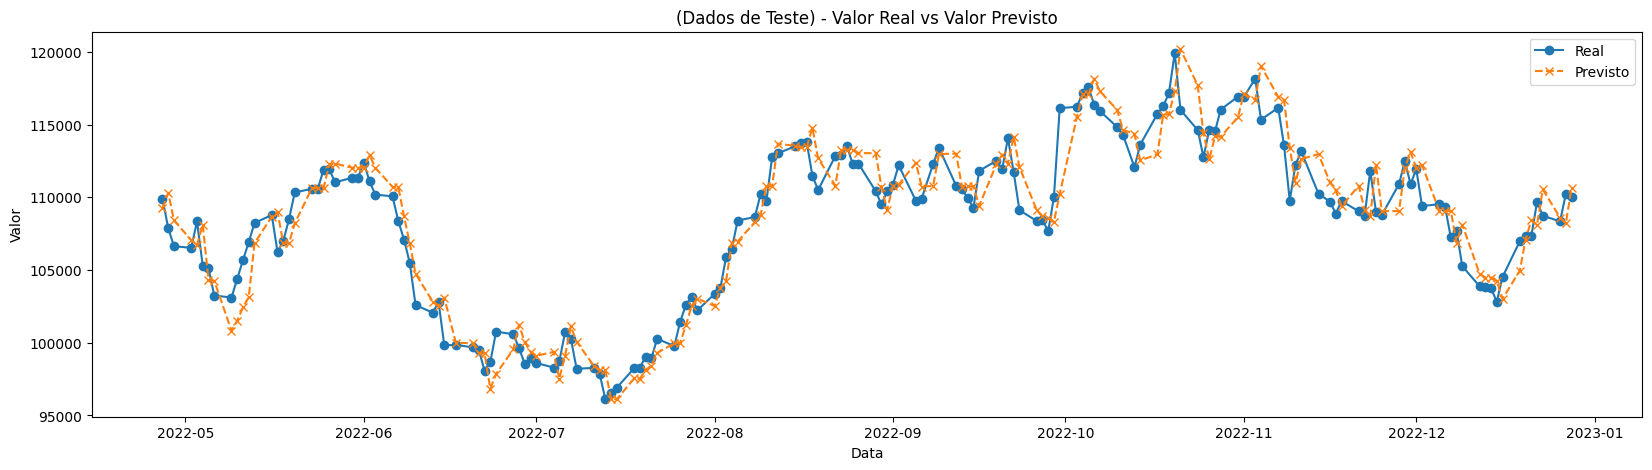

In [55]:
# Treinar o Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_scaled, y_train)

# Fazer previsões com o Gradient Boosting Regressor
y_pred_gbr = gbr_model.predict(X_test_scaled)

# Calcular o erro quadrático médio
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print("Mean Squared Error (Gradient Boosting Regressor):", mse_gbr)

# Plotar os resultados do Gradient Boosting Regressor
plot_real_vs_predicted(y_test, y_pred_gbr)

## lstm

In [58]:
# Função para preparar os dados para o modelo LSTM
def prepare_lstm_data(X, y, window_size=1):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - window_size):
        X_lstm.append(X[i:(i + window_size), :])
        y_lstm.append(y[i + window_size])
    return np.array(X_lstm), np.array(y_lstm)

# Definir o tamanho da janela para o modelo LSTM
window_size = 5

# Preparar os dados para o modelo LSTM
X_train_lstm, y_train_lstm = prepare_lstm_data(X_train_scaled, y_train, window_size)
X_test_lstm, y_test_lstm = prepare_lstm_data(X_test_scaled, y_test, window_size)

# Construir e treinar o modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(window_size, X_train_scaled.shape[1]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(X_train_lstm, y_train_lstm, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

# Fazer previsões com o modelo LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Calcular o erro quadrático médio
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
print("Mean Squared Error (LSTM):", mse_lstm)

# Plotar os resultados do modelo LSTM
plot_real_vs_predicted_numpy(y_test_lstm, y_pred_lstm.flatten())

Epoch 1/100
138/138 [==============================] - 3s 8ms/step - loss: 2207523072.0000 - val_loss: 10164135936.0000
Epoch 2/100
138/138 [==============================] - 1s 4ms/step - loss: 2206479104.0000 - val_loss: 10162533376.0000
Epoch 3/100
138/138 [==============================] - 1s 4ms/step - loss: 2205825792.0000 - val_loss: 10161041408.0000
Epoch 4/100
138/138 [==============================] - 1s 4ms/step - loss: 2205196544.0000 - val_loss: 10159588352.0000
Epoch 5/100
138/138 [==============================] - 1s 4ms/step - loss: 2204571392.0000 - val_loss: 10158149632.0000
Epoch 6/100
138/138 [==============================] - 1s 4ms/step - loss: 2203949312.0000 - val_loss: 10156721152.0000
Epoch 7/100
138/138 [==============================] - 1s 4ms/step - loss: 2203351296.0000 - val_loss: 10155305984.0000
Epoch 8/100
138/138 [==============================] - 1s 4ms/step - loss: 2202744832.0000 - val_loss: 10153892864.0000
Epoch 9/100
138/138 [===================

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 2000x500 with 0 Axes>

# arima

Mean Squared Error (ARIMA): 2567121426.113421


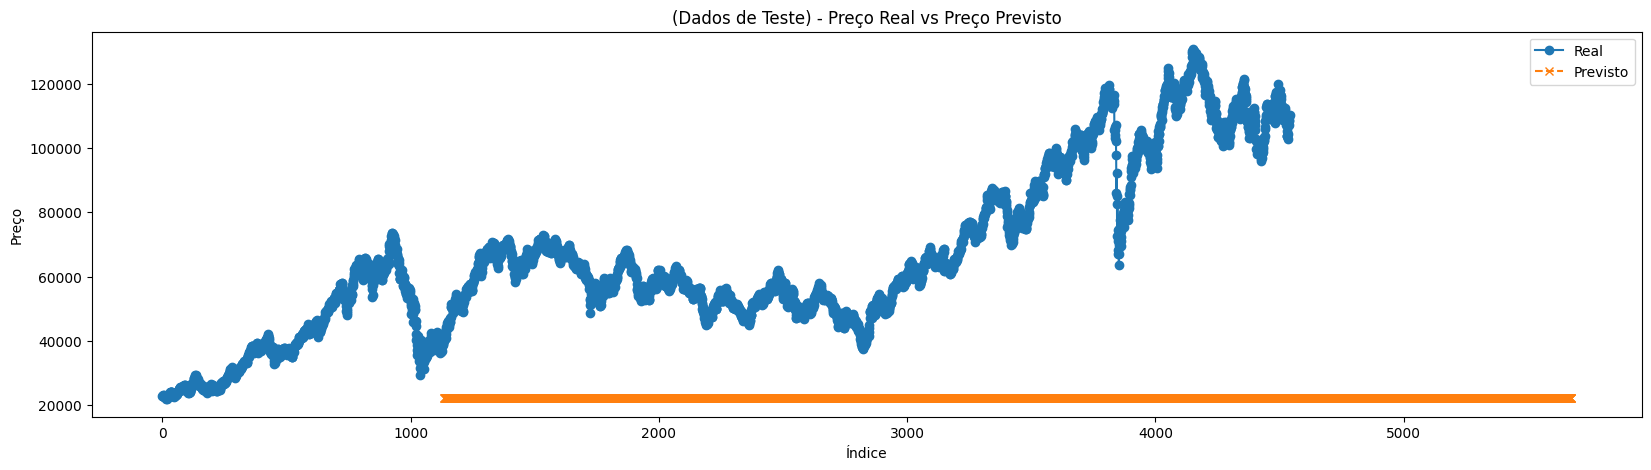

In [80]:
# Função para preparar os dados para o modelo ARIMA
def prepare_arima_data(data, columns):
    return data[columns]

# Preparar os dados para o modelo ARIMA
X_arima = prepare_arima_data(data, ['Close'])

# Dividir os dados em treino e teste
train_size_arima = int(0.2 * len(X_arima))
X_train_arima, X_test_arima = X_arima[:train_size_arima], X_arima[train_size_arima:]

# Treinar o modelo ARIMA
arima_model = ARIMA(X_train_arima, order=(1, 1, 1))
arima_results = arima_model.fit()

# Fazer previsões com o modelo ARIMA
y_pred_arima = arima_results.forecast(steps=len(X_test_arima))

# Calcular o erro quadrático médio
mse_arima = mean_squared_error(X_test_arima.values.flatten(), y_pred_arima)
print("Mean Squared Error (ARIMA):", mse_arima)

# Plotar os resultados do modelo ARIMA
plot_real_vs_predicted_numpy(X_test_arima.values.flatten(), y_pred_arima)


## arima #2

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Divida os dados em treino e teste
train_data = y['2022-01-01':'2022-12-31']
test_data = y['2023-01-01':]

# Use o Auto ARIMA para encontrar o melhor modelo SARIMA
auto_sarima_model = pm.auto_arima(train_data, seasonal=True, m=12, stepwise=True, suppress_warnings=True)
p, d, q = auto_sarima_model.order
P, D, Q, m = auto_sarima_model.seasonal_order

# Treine o melhor modelo SARIMA com os dados de treino
sarima_full_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_full_results = sarima_full_model.fit()

In [ ]:
# Faça previsões para janeiro de 2023 usando a função get_forecast
forecast_steps = len(extended_y) - len(y)
forecast_results = sarima_full_results.get_forecast(steps=forecast_steps)

# Obtenha os valores previstos
y_forecast = forecast_results.predicted_mean

# Anexe as previsões ao conjunto de dados estendido
extended_y[-forecast_steps:] = y_forecast.values


In [35]:
df = data['Close']

In [45]:
df.colums = ['Close']
df

Date
2000-01-21     17034.0
2000-01-24     16972.0
2000-01-26     17105.0
2000-01-27     17081.0
2000-01-28     16734.0
                ...   
2022-12-22    107317.0
2022-12-23    109698.0
2022-12-26    108738.0
2022-12-27    108347.0
2022-12-28    110237.0
Name: Close, Length: 5677, dtype: float64

In [49]:

#Split into train and test
train = df.iloc[:-365]
test  = df.iloc[-365:]
#forecast horizon
h = 3
train_length = len(train)

print('train_length:',train_length, '\ntest_length:', len(test) )

#Creating BoxCox transformed train & test to be used later



train_log = np.log(train)

from pmdarima import ARIMA, auto_arima

(auto_arima(train,
           seasonal=True,
           m=12,                          #seasonality_order 4
           d=1,                          #ACF plot showed we need at least 1 differencing
           information_criterion='aicc'). #You can choose AIC, BIC. AICc is corrected AIC
           summary())

#Creating SARIMA model in Python using statsmodels

sarima_model=(SARIMAX(endog=train["Close"], 
               order=(0,1,1),
               seasonal_order=(1,1,0,12),
               trend='c',
               enforce_invertibility=False))

sarima_fit=sarima_model.fit()

start = len(train)
end = len(train) +len(test) -1

sarima_fitted = sarima_fit.fittedvalues

sarima_resid = sarima_fit.resid

py_sarima = sarima_fit.predict(start, end, dynamic=False)

predictions["py_sarima"] = py_sarima

sarima_fit.plot_diagnostics();

py_sarima2 = sarima_fit.predict(start, end+13, dynamic=False)
pd.DataFrame(py_sarima2)

train_length: 5312 
test_length: 365


KeyError: 'Close'

In [ ]:
import plotly.graph_objects as go

# Crie um objeto de gráfico
fig = go.Figure()

# Adicione os dados reais ao gráfico
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, mode='lines', name='Dados Reais'))

# Adicione as previsões para janeiro de 2023 ao gráfico
fig.add_trace(go.Scatter(x=pd.date_range('2023-01-01', '2023-01-31', freq='D'), y=y_pred_january_2023, mode='lines', name='Previsões Janeiro 2023', line=dict(dash='dash')))

# Configure o layout do gráfico
fig.update_layout(title='Dados Reais e Previsões para Janeiro de 2023', xaxis_title='Data', yaxis_title='Valor')

# Mostre o gráfico
fig.show()


# sarima

Mean Squared Error (SARIMA): 264674859.46967933


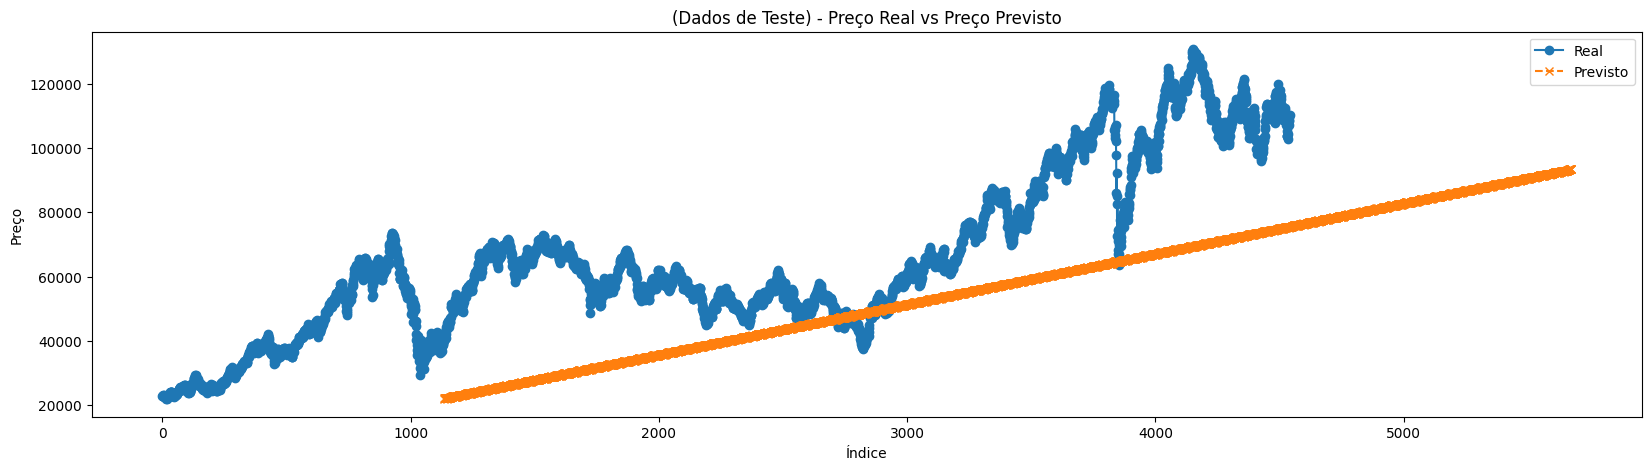

In [81]:
# Treinar o modelo SARIMA
sarima_model = SARIMAX(X_train_arima, order=(1, 1, 0), seasonal_order=(1, 1, 1, 30))
sarima_results = sarima_model.fit()

# Fazer previsões com o modelo SARIMA
y_pred_sarima = sarima_results.forecast(steps=len(X_test_arima))

# Calcular o erro quadrático médio
mse_sarima = mean_squared_error(X_test_arima.values.flatten(), y_pred_sarima)
print("Mean Squared Error (SARIMA):", mse_sarima)

# Plotar os resultados do modelo SARIMA
plot_real_vs_predicted_numpy(X_test_arima.values.flatten(), y_pred_sarima)


## xgboost

Mean Squared Error (XGBoost): 2556109.6924699037


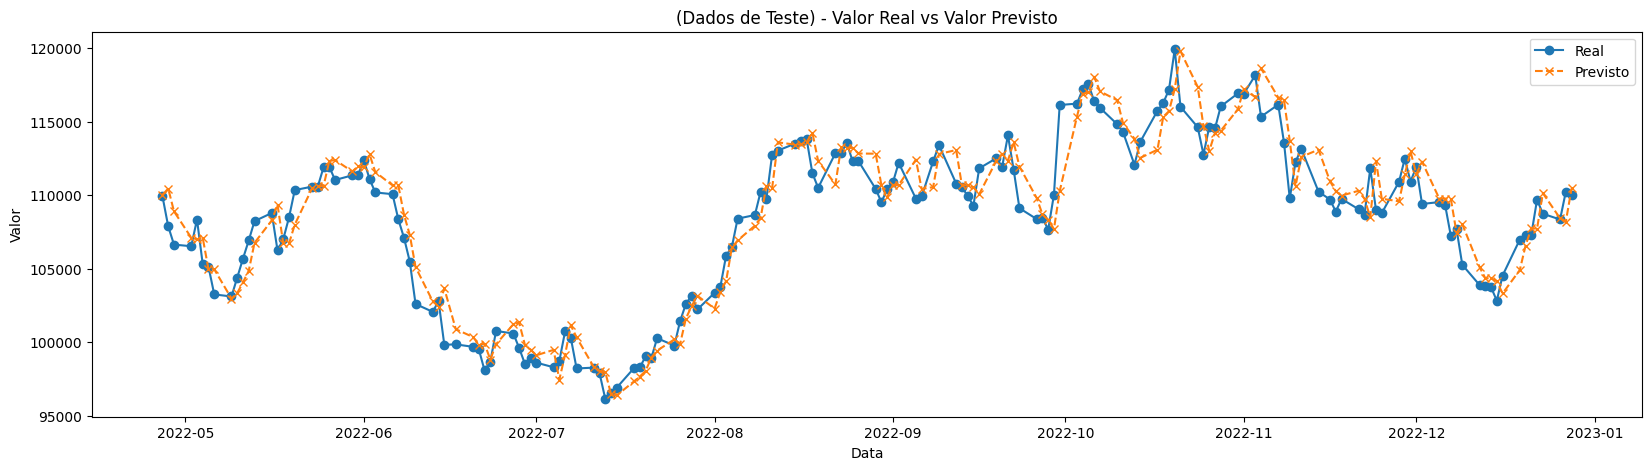

In [84]:
scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

# Treinar o modelo XGBoost
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42)
xgb_reg.fit(X_train_scaled, y_train_scaled)

# Fazer previsões com o modelo XGBoost
y_pred_xgb_scaled = xgb_reg.predict(X_test_scaled)

# Reverter a padronização
y_pred_xgb = scaler_target.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()

# Calcular o erro quadrático médio
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error (XGBoost):", mse_xgb)

# Plotar os resultados do modelo XGBoost
plot_real_vs_predicted(y_test, y_pred_xgb)

## gru

In [ ]:
# Função para criar o modelo GRU
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
y_pred_gru = scaler_target.inverse_transform(y_pred_gru).flatten()

# Criar o modelo GRU
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))

# Treinar o modelo GRU
gru_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

# Fazer previsões com o modelo GRU
y_pred_gru_scaled = gru_model.predict(X_test)

# Reverter a padronização
y_pred_gru = scaler_target.inverse_transform(y_pred_gru).flatten()

# Calcular o erro quadrático médio
mse_gru = mean_squared_error(y_test, y_pred_gru)
print("Mean Squared Error (GRU):", mse_gru)

# Plotar os resultados do modelo GRU
plot_real_vs_predicted_numpy(y_test, y_pred_gru)

## ensemble lstm, xgboost e gru

In [ ]:
# Calcular a média das previsões dos modelos
y_pred_ensemble = (y_pred_lstm + y_pred_xgb + y_pred_gru) / 3

# Calcular o erro quadrático médio
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
print("Mean Squared Error (Ensemble):", mse_ensemble)

# Plotar os resultados do ensemble
plot_real_vs_predicted_numpy(y_test, y_pred_ensemble)

from sklearn.metrics import mean_absolute_error, r2_score

# Calcular o MAE e R² para cada modelo
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Imprimir os resultados
print("LSTM: MAE = {:.4f}, R² = {:.4f}".format(mae_lstm, r2_lstm))
print("XGBoost: MAE = {:.4f}, R² = {:.4f}".format(mae_xgb, r2_xgb))
print("GRU: MAE = {:.4f}, R² = {:.4f}".format(mae_gru, r2_gru))
print("Ensemble: MAE = {:.4f}, R² = {:.4f}".format(mae_ensemble, r2_ensemble))


## h2O #1

In [28]:
# Passo 2: Converter o DataFrame em um objeto H2OFrame
h2o.init()
df_h2o = h2o.H2OFrame(data)

# Passo 3: Separar os dados em conjunto de treino e conjunto de teste
train, test = df_h2o.split_frame(ratios=[0.8])

# Passo 4: Definir os recursos (features) que serão usados para prever o valor da coluna "Close"
features = ['Open', 'High', 'Low', 'Volume', '50ma', '200ma', 'Volatility', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'OBV', 'Close_shift']

# Passo 5: Definir o target (variável dependente) como "Close"
target = 'Close'

# Passo 6: Instanciar o modelo de regressão da H2O
model = H2OGradientBoostingEstimator()

# Passo 7: Treinar o modelo com os dados de treino
model.train(x=features, y=target, training_frame=train)

# Passo 8: Fazer previsões no conjunto de teste
predictions = model.predict(test[features])

# Passo 9: Avaliar a performance do modelo
print(model.r2())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,33 mins 20 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_KAIQUEHENRIQUEVALIM_0l2qqt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.978 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
0.9998307898622648


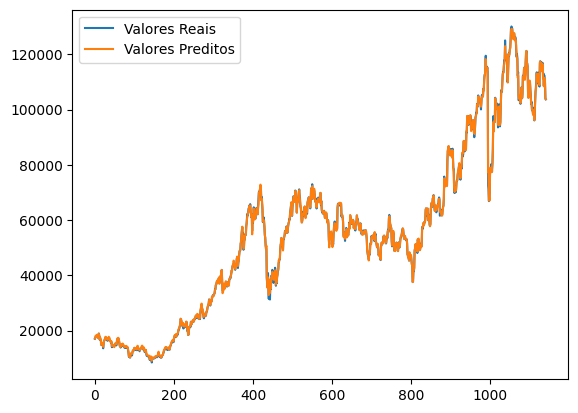

In [29]:
# Converter os dados de teste e preditos para DataFrame
test_df = test.as_data_frame()
pred_df = predictions.as_data_frame()

# Plotar os valores reais e preditos em um gráfico de linha
plt.plot(test_df[target], label='Valores Reais')
plt.plot(pred_df['predict'], label='Valores Preditos')
plt.legend()
plt.show()


## h2O #2

In [85]:
# Inicializar H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,39 mins 51 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_KAIQUEHENRIQUEVALIM_cnhnca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.464 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [86]:
# Converter os DataFrames do pandas para H2OFrames do H2O
train_h2o = h2o.H2OFrame(pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train.reset_index(drop=True)], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([pd.DataFrame(X_test_scaled, columns=X_test.columns), y_test.reset_index(drop=True)], axis=1))

# Definir as colunas de recursos e destino
feature_columns = train_h2o.columns[:-1]
target_column = train_h2o.columns[-1]

# Definir os hiperparâmetros para pesquisa
gbm_params = {
    'ntrees': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learn_rate': [0.01, 0.1, 0.2],
    'sample_rate': [0.8, 0.9, 1.0],
    'col_sample_rate': [0.2, 0.5, 0.8, 1.0]
}

# Inicializar o H2O GBM e o H2O GridSearch
gbm_grid = H2OGradientBoostingEstimator()
grid = H2OGridSearch(gbm_grid, gbm_params)

# Treinar o GridSearch e encontrar o melhor modelo
grid.train(x=feature_columns, y=target_column, training_frame=train_h2o, nfolds=5)
best_gbm = grid.get_grid(sort_by='mse', decreasing=False)[0]

# Fazer previsões com o melhor modelo GBM
y_pred_best_gbm = best_gbm.predict(test_h2o).as_data_frame().values.flatten()

# Calcular o erro quadrático médio
mse_best_gbm = mean_squared_error(y_test, y_pred_best_gbm)
print("Mean Squared Error (Best GBM):", mse_best_gbm)

# Plotar os resultados do melhor modelo GBM
plot_real_vs_predicted_numpy(y_test, y_pred_best_gbm)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Grid Build progress: |███ (cancelled)
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 1.0
Hyper-parameter: learn_rate, 0.01
Hyper-parameter: max_depth, 5
Hyper-parameter: ntrees, 150
Hyper-parameter: sample_rate, 1.0
failure_details: Job Canceled
failure_stack_traces: water.Job$JobCancelledException
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:532)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:405)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1677)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoi

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Mean Squared Error (Deep Learning H2O): 1259676805.66985


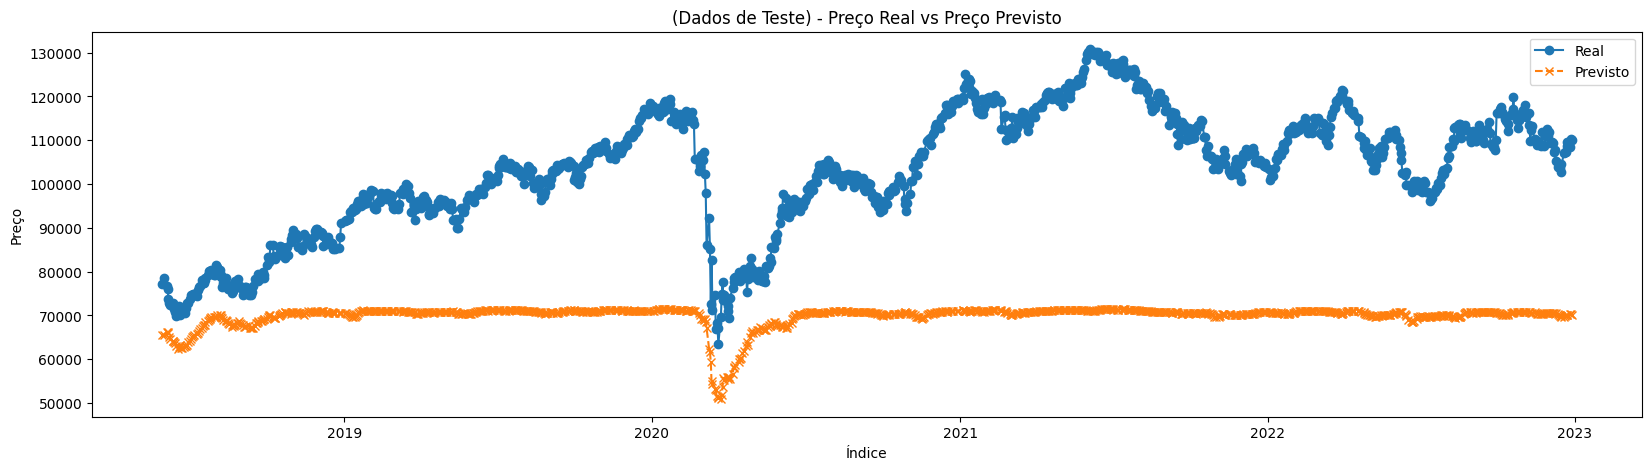

In [17]:
# Treinar um modelo de Deep Learning (Rede Neural Profunda) com H2O
dl_h2o = H2ODeepLearningEstimator(epochs=100, hidden=[200, 200], activation='RectifierWithDropout')
dl_h2o.train(x=feature_columns, y=target_column, training_frame=train_h2o)

# Fazer previsões com o modelo de Deep Learning H2O
y_pred_dl_h2o = dl_h2o.predict(test_h2o).as_data_frame().values.flatten()

# Calcular o erro quadrático médio
mse_dl_h2o = mean_squared_error(y_test, y_pred_dl_h2o)
print("Mean Squared Error (Deep Learning H2O):", mse_dl_h2o)

# Plotar os resultados do modelo Deep Learning H2O
plot_real_vs_predicted_numpy(y_test, y_pred_dl_h2o)

In [ ]:
# Finalizar H2O
h2o.cluster().shutdown()